<a href="https://colab.research.google.com/github/babi00/ai4biological-pattern/blob/main/download_and_analyze_from_iNaturalist/annotate_unnotated_data_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modello che utilizza le immagini (no embedding) e multy-binary classification

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import requests
from io import BytesIO

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
#1.Load and prepare data
class PlantPhenologyDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

        #possible phenology states
        self.phenology_classes = [
            'Flowering',
            'No Evidence of Flowering',
            'Flower Budding',
            'Fruiting'
        ]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
      row = self.dataframe.iloc[idx]
      obs_id = row['observation_id']

      #try to load images: they can have multiple formats
      variants = [f"{obs_id}_1.jpeg", f"{obs_id}_1.jpg", f"{obs_id}_1.JPG", f"{obs_id}_1.png", f"{obs_id}_1.PNG", f"{obs_id}_2.jpg", f"{obs_id}_2.jpeg"]

      image = None

      for filename in variants:
          url = f"{self.img_dir}/{filename}"
          response = requests.get(url)
          if response.status_code == 200:
              try:
                  image = Image.open(BytesIO(response.content)).convert("RGB")
                  break
              except:
                  continue

      if image is None:
          raise FileNotFoundError(f"Could not load any image for observation ID {obs_id}")

      if self.transform:
          image = self.transform(image)

      #one-hot encoded label vector for binary classifications
      label_vector = torch.zeros(len(self.phenology_classes))
      if pd.notna(row['value']):
          for i, phenology_class in enumerate(self.phenology_classes):
              #if this is the correct class, set to 1
              if row['value'] == phenology_class:
                  labels[i] = 1

      return image, label, obs_id

#Data loading function for a single specie
def load_data_single_specie(csv_path, img_dir):
    df = pd.read_csv(csv_path)

    #Split into labeled and unlabeled data
    labeled_df = df[df['value'].notna()].copy()
    unlabeled_df = df[df['value'].isna()].copy()

    print(f"Total observations: {len(df)}")
    print(f"Labeled observations: {len(labeled_df)}")
    print(f"Unlabeled observations: {len(unlabeled_df)}")

    #Split labeled data into train and validation sets
    train_df, val_df = train_test_split(labeled_df, test_size=0.2, random_state=42, stratify=labeled_df['value'])

    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")

    #Define transformations
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    #datasets
    train_dataset = PlantPhenologyDataset(train_df, img_dir, transform=train_transform)
    val_dataset = PlantPhenologyDataset(val_df, img_dir, transform=val_transform)
    unlabeled_dataset = PlantPhenologyDataset(unlabeled_df, img_dir, transform=val_transform)

    #dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=16)

    return train_loader, val_loader, unlabeled_loader, train_dataset.phenology_classes

In [ ]:
#2.Define the model using transfer learning: use ResNet and modify just the last layer
def get_resnet_model(num_classes):
    #Use a pre-trained ResNet18 model
    model = models.resnet18(weights='IMAGENET1K_V1')

    #Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    #Replace the final fully connected layer
    in_ftrs = model.fc.in_features
    model.fc = nn.Linear(in_ftrs, num_classes)
    #Ensure the new fc layer's parameters are trainable
    for param in model.fc.parameters():
        param.requires_grad = True
    return model

In [ ]:
#3. Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc_per_class': [], 'val_acc_per_class': []}
    num_classes = len(train_loader.dataset.phenology_classes)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = torch.zeros(num_classes).to(device)
        total = torch.zeros(num_classes).to(device)

        for images, labels, _ in train_loader:
            #Filter out unlabeled data just to be sure
            mask = labels != -1
            if not torch.any(mask):
                continue

            images, labels = images[mask], labels[mask]
            images, labels = images.to(device), labels.to(device)

            #zero the parameter gradients
            optimizer.zero_grad()

            #forward pass
            outputs = model(images)
            loss = criterion(outputs, labels.float())

            #backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
            top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
            preds[range(probs.size(0)), top_class] = 1
            correct += (preds == labels).sum(dim=0)
            total += labels.size(0)


        #track statistics to draw graph
        epoch_train_loss = running_loss / total.sum().item()
        epoch_train_acc_per_class = (correct / total).cpu().numpy()
        history['train_loss'].append(epoch_train_loss)
        history['train_acc_per_class'].append(epoch_train_acc_per_class)

        #validation phase
        model.eval()
        running_loss = 0.0
        correct = torch.zeros(num_classes).to(device)
        total = torch.zeros(num_classes).to(device)

        with torch.no_grad():
            for images, labels, _ in val_loader:
                mask = labels != -1
                if not torch.any(mask):
                    continue

                images, labels = images[mask], labels[mask]
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)

                probs = torch.sigmoid(outputs)
                preds = torch.zeros_like(probs)
                top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
                preds[range(probs.size(0)), top_class] = 1
                correct += (preds == labels).sum(dim=0)
                total += labels.size(0)

        #track statistics to draw graph
        epoch_val_loss = running_loss / total.sum().item()
        epoch_val_acc_per_class = (correct / total).cpu().numpy()
        history['val_loss'].append(epoch_val_loss)
        history['val_acc_per_class'].append(epoch_val_acc_per_class)

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Validation Loss: {epoch_val_loss:.4f}')

        #Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_phenology_model.pth')

    #Load best model
    model.load_state_dict(torch.load('best_phenology_model.pth'))
    return model, history

In [ ]:
#4. Evaluate the model
def evaluate_model(model, dataloader, device, phenology_classes):
    model.eval()
    all_preds = []
    all_labels = []
    all_ids = []

    with torch.no_grad():
        for images, labels, obs_ids in dataloader:
            mask = labels != -1
            if not torch.any(mask):
                continue

            images, labels = images[mask], labels[mask]
            images = images.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
            top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
            preds[range(probs.size(0)), top_class] = 1

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_ids.extend(obs_ids.numpy())

    print(classification_report(all_labels, all_preds,
                               target_names=list(phenology_classes.keys())))

    #confusion matrix
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Classification report for multi-label
    print(classification_report(all_labels, all_preds, target_names=phenology_classes))

    # Confusion matrix for multi-label
    cm = confusion_matrix(all_labels.flatten(), all_preds.flatten())

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = phenology_classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')


    #Create a DataFrame with results
    results_df = pd.DataFrame({
        'observation_id': all_ids,
        'true_phenology': [idx_to_class[label] for label in all_labels],
        'predicted_phenology': [idx_to_class[pred] for pred in all_preds]
    })

    return results_df

In [ ]:
#5. Make predictions on unlabeled data
def predict_unlabeled(model, dataloader, device, phenology_classes):
    model.eval()
    all_preds = []
    all_ids = []

    with torch.no_grad():
        for images, labels, obs_ids in dataloader:
            images = images.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
            top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
            preds[range(probs.size(0)), top_class] = 1

            all_preds.extend(preds.cpu().numpy())
            all_ids.extend(obs_ids.numpy())

    #Create a DataFrame with predictions
    predictions_df = pd.DataFrame({
        'observation_id': all_ids,
        'predicted_phenology': [idx_to_class[pred] for pred in all_preds]
    })

    return predictions_df

In [ ]:
github_repository = 'https://raw.githubusercontent.com/babi00/ai4biological-pattern/download_and_analyze_iNaturalist/download_and_analyze_from_iNaturalist/PROVA_fragola_verde/'
csv_path = f'{github_repository}annotations_detailed_PROVA_fragola_verde.csv'  # Path to your CSV file
img_dir = f'{github_repository}inat_photos/'  # Directory containing images

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#Load data
train_loader, val_loader, unlabeled_loader, phenology_classes = load_data(csv_path, img_dir)

#Initialize model
model = get_model(num_classes=len(phenology_classes))

#Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss() #for multiple binary classification
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001) #make sure than the optimizer does not modify all layers: only those earlier specified (not freezed)

#Train model
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=15)

# Plot training history for accuracy per class
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
for i in range(len(phenology_classes)):
    plt.plot(history['train_acc_per_class'], label=f'Class {phenology_classes[i]}')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy per Class')
plt.legend()

plt.subplot(2, 1, 2)
for i in range(len(phenology_classes)):
    plt.plot(history['val_acc_per_class'], label=f'Class {phenology_classes[i]}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy per Class')
plt.legend()

plt.tight_layout()
plt.savefig('training_accuracy_per_class.png')

#Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_history.png')

#Evaluate model on validation set
results_df = evaluate_model(model, val_loader, device, phenology_classes)
results_df.to_csv('validation_results.csv', index=False)

#Make predictions on unlabeled data
predictions_df = predict_unlabeled(model, unlabeled_loader, device, phenology_classes)
predictions_df.to_csv('unlabeled_predictions.csv', index=False)

#Merge predictions with original CSV
original_df = pd.read_csv(csv_path)

#Only update rows where Plant Phenology value is missing
mask = (original_df['term'] == 'Plant Phenology') & (original_df['value'].isna())

#Create a dictionary mapping observation_id to predicted phenology
pred_dict = dict(zip(predictions_df['observation_id'], predictions_df['predicted_phenology']))

#Update and save original DataFrame
original_df.loc[mask, 'value'] = original_df.loc[mask, 'observation_id'].map(pred_dict)

original_df.to_csv('updated_data.csv', index=False)
print("Successfully updated phenology data!")

# Modello che utilizza embeddings e multi binary classes
(Download delle immagini in locale)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import requests
from io import BytesIO
from google.colab import drive

torch.manual_seed(42)
np.random.seed(42)

!apt-get install git

# Clone the repository without checking out files
!git clone --filter=blob:none --no-checkout https://github.com/babi00/ai4biological-pattern.git
%cd ai4biological-pattern

# Enable sparse checkout
!git sparse-checkout init --cone
folder_name='PROVA_fragola_verde'
# Set the specific folder you want to download


drive.mount('/content/drive')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Cloning into 'ai4biological-pattern'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 67 (delta 0), reused 0 (delta 0), pack-reused 66 (from 3)
Receiving objects: 100% (67/67), 3.74 MiB | 37.54 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/ai4biological-pattern
Mounted at /content/drive


In [2]:
#1.Load and prepare data
class PlantPhenologyDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

        #possible phenology states
        self.phenology_classes = [
            'Flowering',
            'No Evidence of Flowering',
            'Flower Budding',
            'Fruiting'
        ]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
      row = self.dataframe.iloc[idx]
      obs_id = row['observation_id']

      #try to load images: they can have multiple formats
      variants = [f"{obs_id}_1.jpeg", f"{obs_id}_1.jpg", f"{obs_id}_1.JPG", f"{obs_id}_1.png", f"{obs_id}_1.PNG", f"{obs_id}_2.jpg", f"{obs_id}_2.jpeg"]

      image = None

      for filename in variants:
          local_path = os.path.join(self.img_dir, filename) #locally downloaded
          if os.path.exists(local_path):
              try:
                  image = Image.open(local_path).convert("RGB")
                  break
              except Exception as e:
                  print(f"Failed to open image {filename}: {e}")
              except:
                  continue

      if image is None:
          raise FileNotFoundError(f"Could not load any image for observation ID {obs_id}")

      if self.transform:
          image = self.transform(image)

      #one-hot encoded label vector for binary classifications
      label_vector = torch.zeros(len(self.phenology_classes))
      if pd.notna(row['value']):
          for i, phenology_class in enumerate(self.phenology_classes):
              #if this is the correct class, set to 1
              if row['value'] == phenology_class:
                  label_vector[i] = 1

      return image, label_vector, obs_id

#Data loading function for a single specie
def load_data_single_specie(csv_path, img_dir):
    df = pd.read_csv(csv_path)

    #Split into labeled and unlabeled data
    labeled_df = df[df['value'].notna()].copy()
    unlabeled_df = df[df['value'].isna()].copy()

    print(f"Total observations: {len(df)}")
    print(f"Labeled observations: {len(labeled_df)}")
    print(f"Unlabeled observations: {len(unlabeled_df)}")

    #Split labeled data into train and validation sets
    train_df, val_df = train_test_split(labeled_df, test_size=0.2, random_state=42, stratify=labeled_df['value'])

    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")

    #Define transformations
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    #datasets
    train_dataset = PlantPhenologyDataset(train_df, img_dir, transform=train_transform)
    val_dataset = PlantPhenologyDataset(val_df, img_dir, transform=val_transform)
    unlabeled_dataset = PlantPhenologyDataset(unlabeled_df, img_dir, transform=val_transform)

    #dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=16)

    return train_loader, val_loader, unlabeled_loader, train_dataset.phenology_classes

In [3]:
#2.Define the model using transfer learning: use ResNet and modify just the last layer
def get_resnet_model(num_classes):
    #Use a pre-trained ResNet18 model
    model = models.resnet18(weights='IMAGENET1K_V1')

    #Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    #Replace the final fully connected layer
    in_ftrs = model.fc.in_features
    model.fc = nn.Linear(in_ftrs, num_classes)
    #Ensure the new fc layer's parameters are trainable
    for param in model.fc.parameters():
        param.requires_grad = True
    return model

In [4]:
#3. Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, folder_name, num_epochs=10):
    model.to(device)
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc_per_class': [], 'val_acc_per_class': [], 'train_acc': [],'val_acc': []}
    num_classes = len(train_loader.dataset.phenology_classes)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = torch.zeros(num_classes).to(device)
        total = torch.zeros(num_classes).to(device)

        for images, labels, _ in train_loader:

            images, labels = images.to(device), labels.to(device)

            #zero the parameter gradients
            optimizer.zero_grad()

            #forward pass
            outputs = model(images)
            loss = criterion(outputs, labels.float())

            #backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
            top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
            preds[range(probs.size(0)), top_class] = 1
            correct += (preds == labels).sum(dim=0)
            total += labels.size(0)


        #track statistics to draw graph
        epoch_train_loss = running_loss / total.sum().item()
        epoch_train_acc_per_class = (correct / total).cpu().numpy()
        epoch_train_acc = correct.sum().item() / total.sum().item()
        epoch_val_acc = correct.sum().item() / total.sum().item()
        history['train_loss'].append(epoch_train_loss)
        history['train_acc_per_class'].append(epoch_train_acc_per_class)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        #validation phase
        model.eval()
        running_loss = 0.0
        correct = torch.zeros(num_classes).to(device)
        total = torch.zeros(num_classes).to(device)

        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)

                probs = torch.sigmoid(outputs)
                preds = torch.zeros_like(probs)
                top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
                preds[range(probs.size(0)), top_class] = 1
                correct += (preds == labels).sum(dim=0)
                total += labels.size(0)

        #track statistics to draw graph
        epoch_val_loss = running_loss / total.sum().item()
        epoch_val_acc_per_class = (correct / total).cpu().numpy()
        history['val_loss'].append(epoch_val_loss)
        history['val_acc_per_class'].append(epoch_val_acc_per_class)

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Validation Loss: {epoch_val_loss:.4f}')

    torch.save(model.state_dict(), f'{folder_name}.pth')
    google_drive_path = f'/content/drive/MyDrive/TESI - PoliTO/phenology_models/{folder_name}.pth'
    torch.save(model.state_dict(), google_drive_path)
    model.load_state_dict(torch.load(f'{folder_name}.pth'))
    return model, history

In [5]:
#4. Evaluate the model
def evaluate_model(model, dataloader, device, phenology_classes, folder_name):
    model.eval()
    all_preds = []
    all_labels = []
    all_ids = []

    with torch.no_grad():
        for images, labels, obs_ids in dataloader:
            images = images.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
            top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
            preds[range(probs.size(0)), top_class] = 1

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_ids.extend(obs_ids.numpy())


    print(classification_report(all_labels, all_preds, target_names=phenology_classes))

    #confusion matrix
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = multilabel_confusion_matrix(all_labels, all_preds)
    class_names = phenology_classes

    n_classes = len(class_names)
    cols = 2
    rows = (n_classes + 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten()

    for i in range(n_classes):
        ax = axes[i]
        cmat = cm[i]
        im = ax.imshow(cmat, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(f'"{class_names[i]}"')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Not Present', 'Present'])
        ax.set_yticklabels(['Not Present', 'Present'])
        ax.set_ylabel('True')
        ax.set_xlabel('Predicted')

        thresh = cmat.max() / 2
        for j in range(2):
            for k in range(2):
                ax.text(k, j, format(cmat[j, k], 'd'),
                        ha="center", va="center",
                        color="white" if cmat[j, k] > thresh else "black")

    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f'all_confusion_matrices_{folder_name}.png')
    plt.show()


    #Create a DataFrame with results
    results_df = pd.DataFrame({
        'observation_id': all_ids,
        'true_phenology': [phenology_classes[np.argmax(label)] for label in all_labels], # Use np.argmax to get the index of the true class
        'predicted_phenology': [phenology_classes[np.argmax(pred)] for pred in all_preds] # Use np.argmax to get the index of the predicted class
    })

    return results_df

In [6]:
#5. Make predictions on unlabeled data
def predict_unlabeled(model, dataloader, device, phenology_classes):
    model.eval()
    all_preds = []
    all_ids = []

    with torch.no_grad():
        for images, labels, obs_ids in dataloader:
            images = images.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
            top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
            preds[range(probs.size(0)), top_class] = 1

            all_preds.extend(preds.cpu().numpy())
            all_ids.extend(obs_ids.numpy())

    #Create a DataFrame with predictions
    predictions_df = pd.DataFrame({
        'observation_id': all_ids,
        'predicted_phenology': [phenology_classes[np.argmax(pred)] for pred in all_preds]
    })

    return predictions_df

In [7]:
def create_model_and_predict(folder_name):


    #to download from github
    #github_repository = 'https://raw.githubusercontent.com/babi00/ai4biological-pattern/download_and_analyze_iNaturalist/download_and_analyze_from_iNaturalist/PROVA_fragola_verde/'
    #to retrieve from locally downloaded repository
    github = '/content/ai4biological-pattern/download_and_analyze_from_iNaturalist'
    github_repository = f'{github}/{folder_name}/'
    csv_path = f'{github_repository}annotations_detailed_{folder_name}.csv'  # Path to your CSV file
    img_dir = f'{github_repository}inat_photos/'  # Directory containing images

    if not os.path.isdir(github_repository): #check if data has already been downloaded
        !git sparse-checkout set download_and_analyze_from_iNaturalist/{folder_name}
        !git checkout main

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    #Load data
    train_loader, val_loader, unlabeled_loader, phenology_classes = load_data_single_specie(csv_path, img_dir)

    #Initialize model
    model = get_resnet_model(num_classes=len(phenology_classes))

    #Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss() #for multiple binary classification
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001) #make sure than the optimizer does not modify all layers: only those earlier specified (not freezed)

    #Train model
    model, history = train_model(model, train_loader, val_loader, criterion, optimizer, device, folder_name, num_epochs=15)

    # Plot training history for accuracy per class
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    for i in range(len(phenology_classes)):
        acc = [epoch[i] for epoch in history['train_acc_per_class']]
        plt.plot(acc, label=f'Train - {phenology_classes[i]}')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy per Class')
    plt.legend()

    plt.subplot(2, 1, 2)
    for i in range(len(phenology_classes)):
        acc = [epoch[i] for epoch in history['val_acc_per_class']]
        plt.plot(acc, label=f'Val - {phenology_classes[i]}')
    plt.xlabel('Epoch')
    plt.ylabel('Val Accuracy per Class')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'training_accuracy_per_class_{folder_name}.png')
    plt.show()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'training_history_{folder_name}.png')
    plt.show()

    #Evaluate model on validation set
    results_df = evaluate_model(model, val_loader, device, phenology_classes, folder_name)
    results_df.to_csv(f'validation_results_{folder_name}.csv', index=False)

    #Make predictions on unlabeled data
    predictions_df = predict_unlabeled(model, unlabeled_loader, device, phenology_classes)
    predictions_df.to_csv(f'unlabeled_predictions_{folder_name}.csv', index=False)

    #Merge predictions with original CSV
    original_df = pd.read_csv(csv_path)

    #Only update rows where Plant Phenology value is missing
    mask = (original_df['term'] == 'Plant Phenology') & (original_df['value'].isna())

    #Create a dictionary mapping observation_id to predicted phenology
    pred_dict = dict(zip(predictions_df['observation_id'], predictions_df['predicted_phenology']))

    #Update and save original DataFrame
    original_df.loc[mask, 'value'] = original_df.loc[mask, 'observation_id'].map(pred_dict)

    original_df.to_csv(f'updated_data_{folder_name}.csv', index=False)
    google_drive_path = f'/content/drive/MyDrive/TESI - PoliTO/updated_data_{folder_name}.csv'
    original_df.to_csv(google_drive_path, index=False)

    print("Successfully updated phenology data!")

remote: Enumerating objects: 15645, done.
remote: Total 15645 (delta 0), reused 0 (delta 0), pack-reused 15645 (from 2)
Receiving objects: 100% (15645/15645), 100.73 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (15675/15675), done.
Already on 'main'
Your branch is up to date with 'origin/main'.
Using device: cuda
Total observations: 10487
Labeled observations: 781
Unlabeled observations: 9706
Training set size: 624
Validation set size: 157


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 230MB/s]


Epoch 1/15: Train Loss: 0.1305, Validation Loss: 0.1164
Epoch 2/15: Train Loss: 0.1109, Validation Loss: 0.1075
Epoch 3/15: Train Loss: 0.1017, Validation Loss: 0.1023
Epoch 4/15: Train Loss: 0.0974, Validation Loss: 0.0987
Epoch 5/15: Train Loss: 0.0897, Validation Loss: 0.0939
Epoch 6/15: Train Loss: 0.0858, Validation Loss: 0.0928
Epoch 7/15: Train Loss: 0.0857, Validation Loss: 0.0959
Epoch 8/15: Train Loss: 0.0848, Validation Loss: 0.0903
Epoch 9/15: Train Loss: 0.0831, Validation Loss: 0.0893
Epoch 10/15: Train Loss: 0.0813, Validation Loss: 0.0884
Epoch 11/15: Train Loss: 0.0785, Validation Loss: 0.0870
Epoch 12/15: Train Loss: 0.0795, Validation Loss: 0.0907
Epoch 13/15: Train Loss: 0.0802, Validation Loss: 0.0870
Epoch 14/15: Train Loss: 0.0775, Validation Loss: 0.0873
Epoch 15/15: Train Loss: 0.0764, Validation Loss: 0.0855


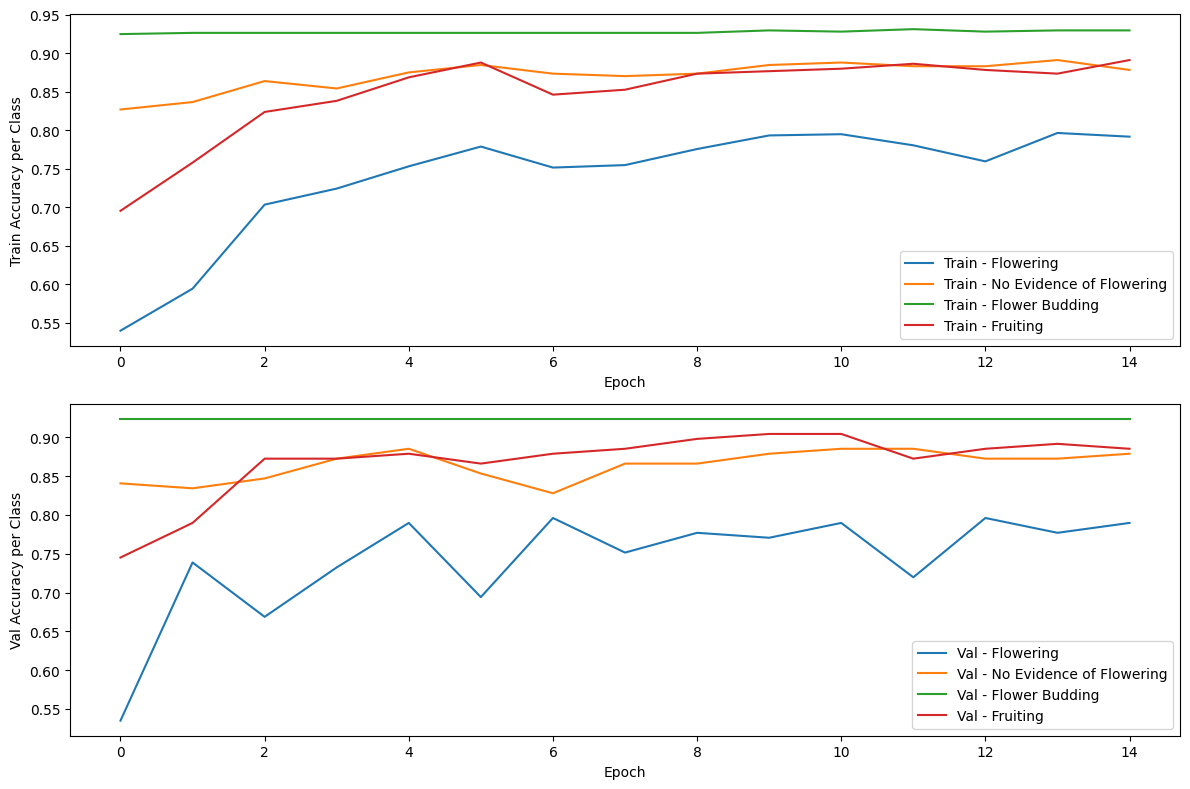

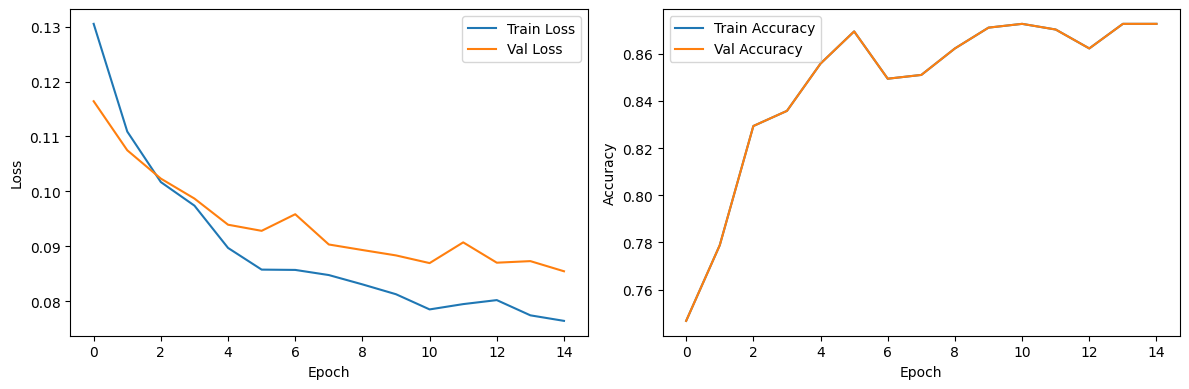

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

               Flowering       0.73      0.91      0.81        78
No Evidence of Flowering       0.68      0.50      0.58        26
          Flower Budding       0.00      0.00      0.00        12
                Fruiting       0.78      0.78      0.78        41

               micro avg       0.74      0.74      0.74       157
               macro avg       0.55      0.55      0.54       157
            weighted avg       0.68      0.74      0.70       157
             samples avg       0.74      0.74      0.74       157



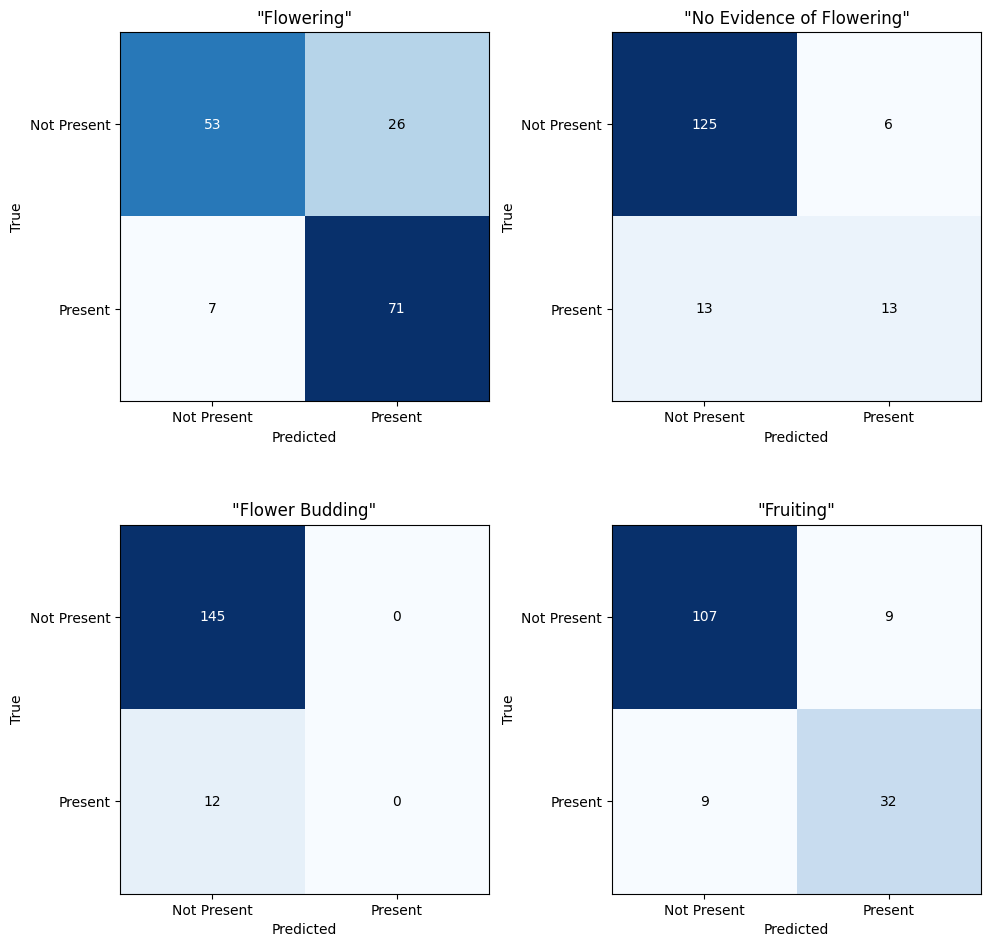

Successfully updated phenology data!


In [8]:
create_model_and_predict('PROVA_fragola_verde')